# Energy Consumption Time Series Forecasting

## Objective
The objective of this project is to forecast short-term household energy
consumption using historical time series data and compare different
forecasting models.


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv(
    "household_power_consumption_input.txt",
    sep=';',
    low_memory=False
)


In [3]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [4]:

df.shape


(2075259, 9)

In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [6]:
df['Datetime'] = pd.to_datetime(
    df['Date'] + ' ' + df['Time'],
    dayfirst=True,
    errors='coerce'
)


In [7]:
df.set_index('Datetime', inplace=True)


In [8]:
df.drop(['Date', 'Time'], axis=1, inplace=True)


In [9]:
df.head()


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [10]:
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')


In [11]:
df.isna().sum()


Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [12]:
df.dropna(inplace=True)


In [13]:
power = df['Global_active_power']
power.head()


Datetime
2006-12-16 17:24:00    4.216
2006-12-16 17:25:00    5.360
2006-12-16 17:26:00    5.374
2006-12-16 17:27:00    5.388
2006-12-16 17:28:00    3.666
Name: Global_active_power, dtype: float64

In [14]:
power_hourly = power.resample('H').mean()


C:\Users\Faizan\AppData\Local\Temp\ipykernel_3928\3406262248.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  power_hourly = power.resample('H').mean()


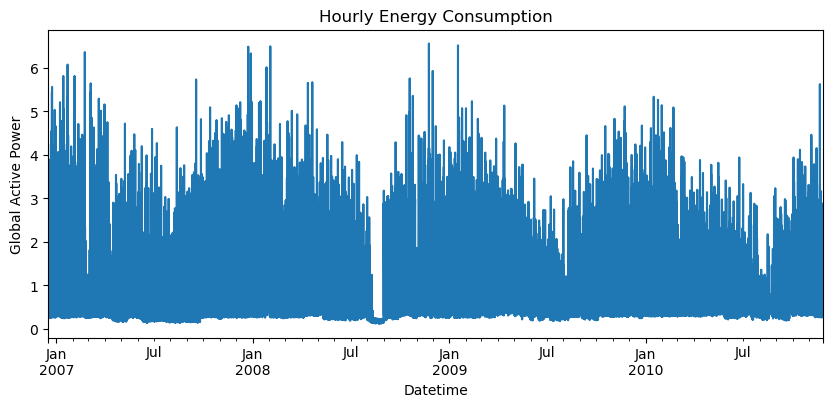

In [15]:
plt.figure(figsize=(10,4))
power_hourly.plot()
plt.title("Hourly Energy Consumption")
plt.ylabel("Global Active Power")
plt.show()


### Time Series Resampling
The Global Active Power variable was selected as the target.
The data was resampled to hourly frequency using mean aggregation
to reduce noise and capture temporal patterns.


In [16]:
df_hourly = power_hourly.to_frame(name='Global_active_power')


### Feature Engineering
Time-based features such as hour of day, day of week, and weekend indicator
were extracted to capture temporal consumption patterns.


In [17]:
df_hourly['hour'] = df_hourly.index.hour
df_hourly['dayofweek'] = df_hourly.index.dayofweek
df_hourly['is_weekend'] = df_hourly['dayofweek'].isin([5, 6]).astype(int)


In [18]:
df_hourly.head()


,Global_active_power,hour,dayofweek,is_weekend
Datetime,,,,
2006-12-16 17:00:00,4.222889,17,5,1
2006-12-16 18:00:00,3.632200,18,5,1
2006-12-16 19:00:00,3.400233,19,5,1
2006-12-16 20:00:00,3.268567,20,5,1
2006-12-16 21:00:00,3.056467,21,5,1


In [19]:
train_size = int(len(df_hourly) * 0.8)

train = df_hourly.iloc[:train_size]
test = df_hourly.iloc[train_size:]


In [20]:
train.shape, test.shape


((27671, 4), (6918, 4))

### ARIMA Evaluation
The ARIMA model was evaluated using MAE and RMSE metrics.
These metrics quantify the average and squared forecasting errors respectively.


In [21]:
from statsmodels.tsa.arima.model import ARIMA


In [22]:
arima_model = ARIMA(
    train['Global_active_power'],
    order=(5,1,0)
)
arima_fit = arima_model.fit() # ARIMA Model Training 


In [23]:
arima_forecast = arima_fit.forecast(steps=len(test))
# Forecast

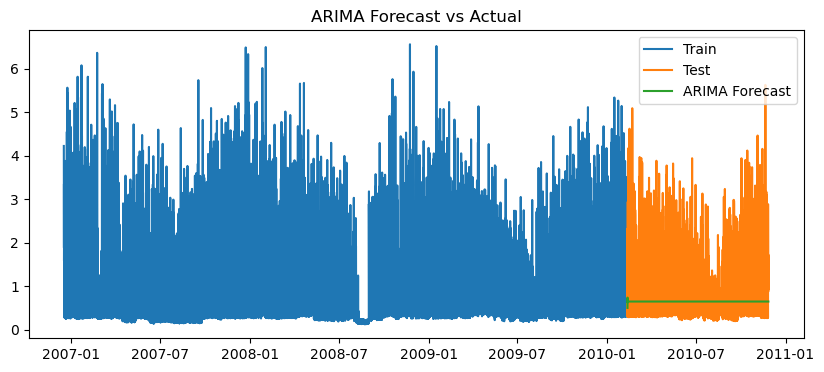

In [24]:
plt.figure(figsize=(10,4))
plt.plot(train.index, train['Global_active_power'], label='Train')
plt.plot(test.index, test['Global_active_power'], label='Test')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast')
plt.legend()
plt.title("ARIMA Forecast vs Actual")
plt.show()


In [25]:
arima_forecast = pd.Series(arima_forecast, index=test.index)


In [26]:
eval_df = pd.concat(
    [test['Global_active_power'], arima_forecast],
    axis=1
)

eval_df.columns = ['actual', 'predicted']

eval_df.dropna(inplace=True)


In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


In [28]:
mae_arima = mean_absolute_error(eval_df['actual'], eval_df['predicted'])
rmse_arima = np.sqrt(mean_squared_error(eval_df['actual'], eval_df['predicted']))

mae_arima, rmse_arima


(0.5934073027008006, np.float64(0.8187475696982677))

### Prophet Model
Prophet is a time series forecasting model developed by Facebook.
It handles seasonality, trends, and holidays automatically.
The model was trained on hourly energy consumption and evaluated on the test set using MAE and RMSE.


In [29]:
!pip install prophet


In [30]:
from prophet import Prophet


In [31]:
prophet_df = df_hourly.reset_index()[['Datetime', 'Global_active_power']]
prophet_df.rename(columns={'Datetime':'ds', 'Global_active_power':'y'}, inplace=True)


In [32]:
prophet_df.head()


,ds,y
0,2006-12-16 17:00:00,4.222889
1,2006-12-16 18:00:00,3.632200
2,2006-12-16 19:00:00,3.400233
3,2006-12-16 20:00:00,3.268567
4,2006-12-16 21:00:00,3.056467


In [33]:
train_size = int(len(prophet_df) * 0.8)

train_prophet = prophet_df.iloc[:train_size]
test_prophet = prophet_df.iloc[train_size:]


In [34]:
m = Prophet()
m.fit(train_prophet)


02:44:33 - cmdstanpy - INFO - Chain [1] start processing
02:44:45 - cmdstanpy - INFO - Chain [1] done processing


In [35]:
future = m.make_future_dataframe(periods=len(test_prophet), freq='H')


D:\anaconda3\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


In [36]:
forecast = m.predict(future)


In [37]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
34584,2010-11-26 17:00:00,1.348373,0.383525,2.262243
34585,2010-11-26 18:00:00,1.726025,0.737213,2.685938
34586,2010-11-26 19:00:00,2.152523,1.182142,3.108876
34587,2010-11-26 20:00:00,2.354906,1.358784,3.357166
34588,2010-11-26 21:00:00,2.195000,1.243951,3.211493


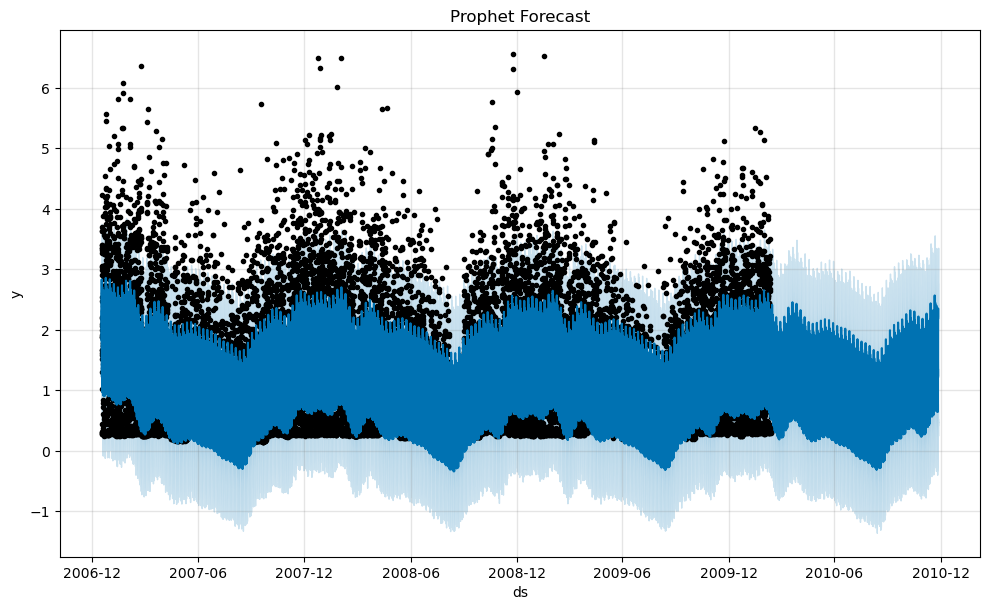

In [38]:
fig1 = m.plot(forecast)
plt.title("Prophet Forecast")
plt.show()


In [39]:
eval_prophet = pd.DataFrame({
    'actual': test_prophet['y'].values,
    'predicted': forecast['yhat'].iloc[-len(test_prophet):].values
})


In [40]:
eval_prophet.dropna(inplace=True)


In [41]:
mae_prophet = mean_absolute_error(
    eval_prophet['actual'],
    eval_prophet['predicted']
)

rmse_prophet = np.sqrt(
    mean_squared_error(
        eval_prophet['actual'],
        eval_prophet['predicted']
    )
)

mae_prophet, rmse_prophet


(0.4847827888787923, np.float64(0.6369828877295624))

### XGBoost Forecasting
Lag features and time-based features were created to transform the time series
problem into a supervised learning task. XGBoost was trained and evaluated using
MAE and RMSE metrics.


In [42]:
df_ml = df_hourly.copy()

df_ml['lag_1'] = df_ml['Global_active_power'].shift(1)
df_ml['lag_2'] = df_ml['Global_active_power'].shift(2)
df_ml['lag_3'] = df_ml['Global_active_power'].shift(3)


In [43]:
df_ml.dropna(inplace=True) # Remove NaNs.


In [44]:
X = df_ml[['hour', 'dayofweek', 'is_weekend', 'lag_1', 'lag_2', 'lag_3']] # Defining Features and Target
y = df_ml['Global_active_power']


In [45]:
split = int(len(df_ml) * 0.8) # Train-Test Spliting

X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]


In [46]:
!pip install xgboost


In [47]:
from xgboost import XGBRegressor # Model Training

xgb_model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

xgb_model.fit(X_train, y_train)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [48]:
y_pred_xgb = xgb_model.predict(X_test) # Prediction


In [49]:
from sklearn.metrics import mean_absolute_error, mean_squared_error # Evaluate XGBoost
import numpy as np

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

mae_xgb, rmse_xgb


(0.34651362169195127, np.float64(0.4927278771512266))

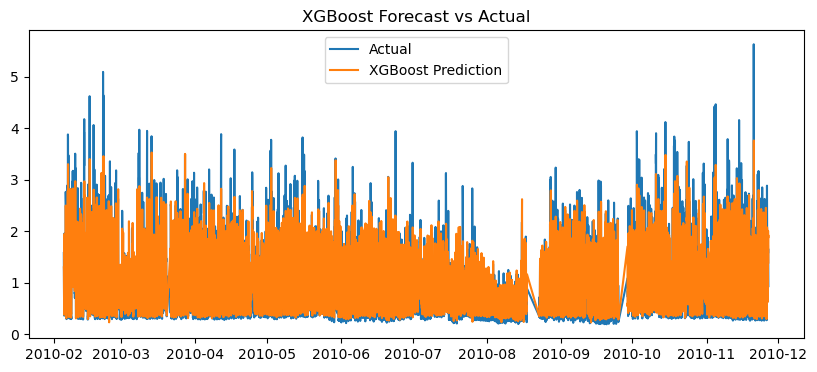

In [50]:
plt.figure(figsize=(10,4)) # Plot Predictions
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred_xgb, label='XGBoost Prediction')
plt.legend()
plt.title("XGBoost Forecast vs Actual")
plt.show()


### Model Comparison
XGBoost achieved the lowest error due to its ability to learn nonlinear
patterns using lag features, outperforming classical time series models.


In [51]:
results = pd.DataFrame({
    'Model': ['ARIMA', 'Prophet', 'XGBoost'],
    'MAE': [mae_arima, mae_prophet, mae_xgb],
    'RMSE': [rmse_arima, rmse_prophet, rmse_xgb]
})

results


,Model,MAE,RMSE
0,ARIMA,0.593407,0.818748
1,Prophet,0.484783,0.636983
2,XGBoost,0.346514,0.492728


In [52]:
forecast_df = pd.DataFrame({
    "Date": test.index,
    "Actual": test['Global_active_power'].values,
    "Forecast": arima_forecast
})

forecast_df.to_csv("task3_forecast_output.csv", index=False)
